# **Noor Abo Elfool - Reinforcement Learning Project**

The outputs presented correspond to the most recent training session, which prematurely terminated at episode 32,395 due to a Colab session crash. To mitigate potential data loss, model checkpoints were systematically saved to Google Drive at intervals of 1,000 episodes. The final video, displayed in the concluding cell, was generated using the most recent available checkpoint. Training was executed on a T4 GPU instance.

Reward progression and training dynamics are illustrated in the preceding visualization. Episode-wise rewards were continuously logged throughout the training process and plotted to depict performance trends over time. Additionally, an aggregated reward plot was produced, summarizing the mean reward at every 1,000-episode milestone to provide a clearer overview of long-term learning behavior.

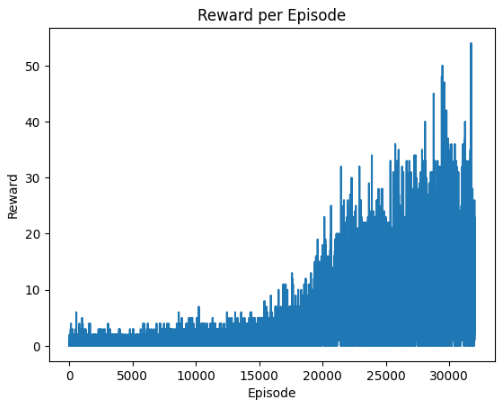

# Deep Q-Network for Atari Breakout.

This project implements a Deep Q-Network (DQN) agent to play the Atari game Breakout.

The implementation includes training the agent using reinforcement learning, logging reward progression, and visualizing the performance. A plot of the rewards during training is generated, along with a video demonstrating the agent's gameplay in a full episode after training.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Breakout

This project uses an environment that emulates the Atari game Breakout. The objective is to break all the bricks in the wall while preventing the ball from touching the floor. The agent has 5 lives and earns more points for hitting higher-positioned bricks compared to lower ones.

The environment provides observations in the form of images with dimensions (210, 160, 3).

The available actions are:

- NOOP (No operation)

- FIRE (Launch the ball)

- LEFT (Move the paddle left)

- RIGHT (Move the paddle right)

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


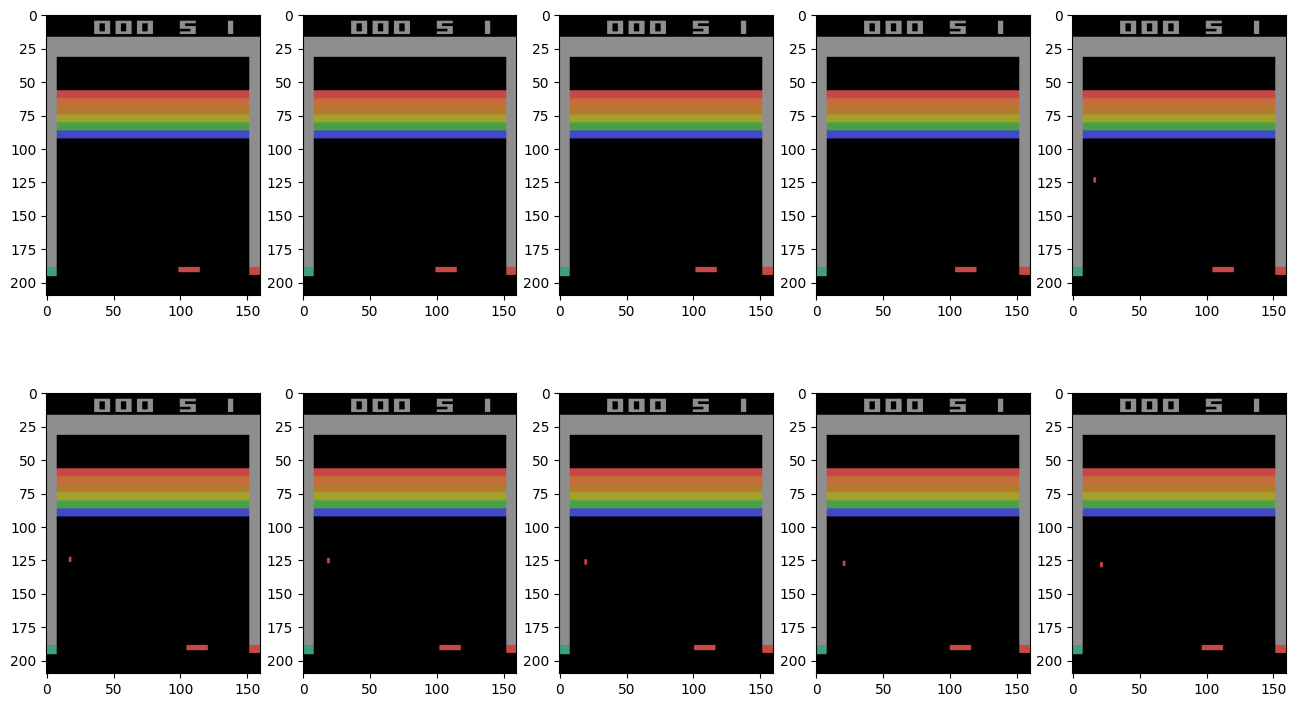

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()


## Environment Wrappers
To optimize the environment for reinforcement learning training, several modifications are applied using environment wrappers:

1. Image Preprocessing – The images are cropped to retain only relevant parts, converted to grayscale, and resized to 64×64 to reduce computational complexity.

2. Frame Stacking – The last four frames are stacked to help the agent capture temporal dynamics.

3. Automatic Fire Action – The episode starts with an automatic fire action to ensure the game begins immediately.

4. Action Repetition – Each selected action is repeated for four time steps to enhance stability.

5. Frame Maximization – The maximum pixel values from the last two frames are taken to prevent flickering effects.

6. Life-Based Done Signal – A "done" signal is triggered when a life is lost, but the environment resets only when all lives are depleted.

7. Reward Clipping – Rewards are binned into {-1, 0, 1} to stabilize training.

These modifications improve training efficiency and help the agent learn more effectively.



In [ ]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 84, 84)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

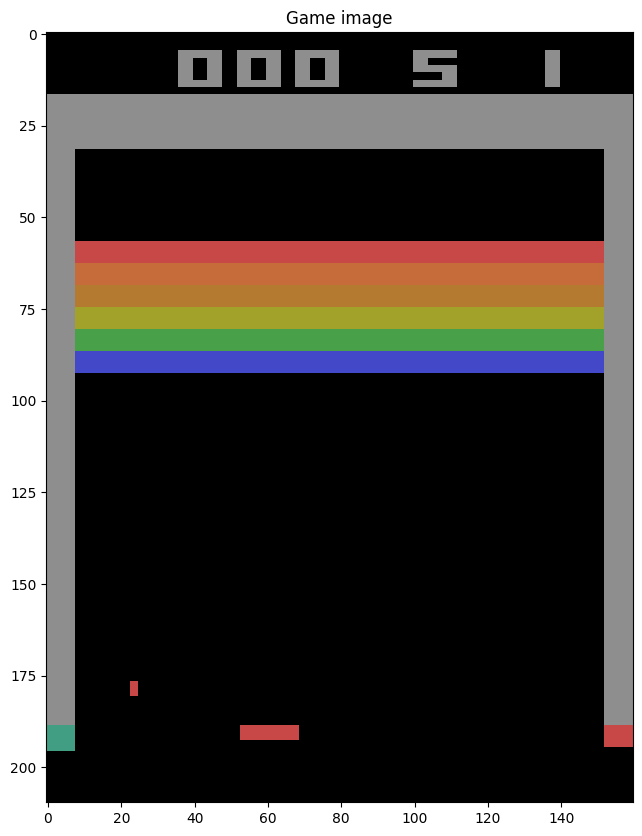

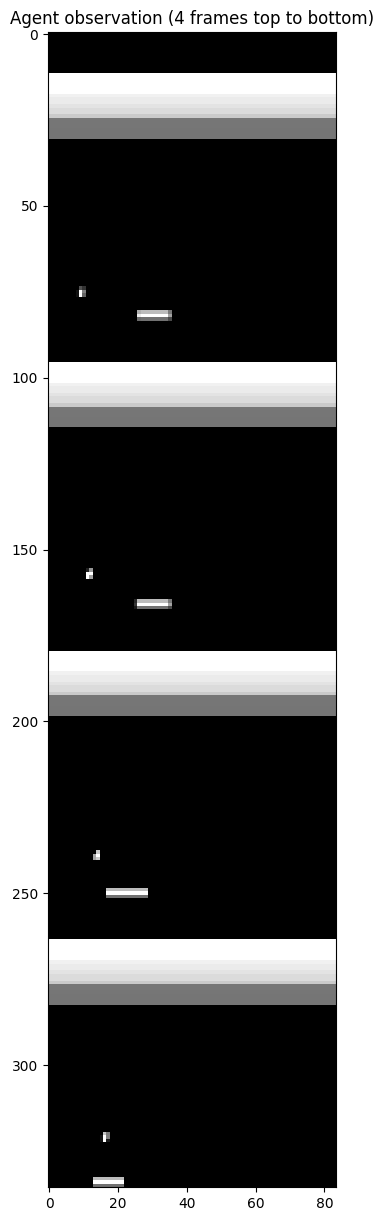

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

A random agent is implemented for evaluation purposes. This agent selects actions randomly and is used within the evaluate function, which runs the agent through multiple episodes.

This serves as a baseline to compare against the performance of the trained Deep Q-Network (DQN) agent.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

##Project Implementation
This project involves developing a Deep Q-Network (DQN) agent for the Atari Breakout environment. The implementation includes:

1. Neural Network – A deep neural network that predicts Q-values for a given state.

2. Experience Replay Buffer – A memory buffer that stores transitions to improve training stability.

3. Target Q-Network – A secondary network that periodically copies the weights of the main Q-network to stabilize learning.

Additionally, a training loop is implemented to update the agent’s policy. The results include a plot showing the reward progression over training steps and a video demonstrating the agent's performance in a full episode.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from gym.wrappers import AtariPreprocessing, FrameStack

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the environment


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, n_actions):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(env.observation_space.shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(self.feature_size(env.observation_space.shape), 512)
        self.fc5 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))) \
            .view(1, -1).size(1)


class DQNAgent():
    def __init__(
        self,
        env,
        seed=42,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_max=1.0,
        epsilon_interval=0.9,
        batch_size=32,
        max_steps_per_episode=10000,
        max_episodes=10,
        lr=0.00025,
        begining_frames_exploration=50000,
        update_target_freq = 10000,
        replay_buffer_capacity=10000

    ):
        self.env = env
        self.num_actions = self.env.action_space.n
        self.replay_buffer = ReplayBuffer(replay_buffer_capacity)

        self.model = QNetwork(self.num_actions).to(device)
        self.model_target = QNetwork(self.num_actions).to(device)
        self.model_target.load_state_dict(self.model.state_dict())
        self.model_target.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_function = nn.HuberLoss()

        self.seed = seed
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_interval = epsilon_interval
        self.batch_size = batch_size
        self.max_steps_per_episode = max_steps_per_episode
        self.max_episodes = max_episodes
        self.begining_frames_exploration= begining_frames_exploration
        self.update_target_freq=update_target_freq
        self.running_reward = 0
        self.episode_reward_history = []
        self.frame_count = 0

    def epsilon_greedy_action(self, state):
        if self.frame_count < self.begining_frames_exploration or self.epsilon > np.random.rand(1)[0]:
            return np.random.choice(self.num_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = self.model(state_tensor)
            return torch.argmax(action_probs).item()

    def update_target_network(self):
        if self.frame_count % self.update_target_freq == 0:
            self.model_target.load_state_dict(self.model.state_dict())

    def train_step(self):
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        state_sample = torch.FloatTensor(state).to(device)
        state_next_sample = torch.FloatTensor(next_state).to(device)

        action_sample = torch.LongTensor(action).to(device)
        rewards_sample = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done_sample = torch.FloatTensor(done).unsqueeze(1).to(device)

        q_values = self.model(state_sample)
        next_q_values = self.model_target(state_next_sample)
        updated_q_values = rewards_sample + self.gamma * torch.max(next_q_values, dim=1)[0].unsqueeze(1) * (1 - done_sample)
        q_action = q_values.gather(1, action_sample.unsqueeze(1))
        loss = self.loss_function(q_action, updated_q_values)

        if self.frame_count % self.update_target_freq == 0:
            print(f"loss: {loss:.4f}")
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        while True:
            observation = self.env.reset()
            state = np.array(observation)
            episode_reward = 0

            for timestep in range(1, self.max_steps_per_episode):
                self.frame_count += 1
                action = self.epsilon_greedy_action(state)
                self.epsilon -= (self.epsilon_interval / 1000000 )
                self.epsilon = max(self.epsilon, self.epsilon_min)
                state_next, reward, done, _ = self.env.step(action)
                state_next = np.array(state_next)
                episode_reward += reward
                self.replay_buffer.push(state, action, reward, state_next, done)
                state = state_next
                if self.frame_count % 4 == 0 and len(self.replay_buffer.buffer) > self.batch_size:
                    self.train_step()
                self.update_target_network()
                if done:
                    break
            self.episode_reward_history.append(episode_reward)
            if len(self.episode_reward_history)%1000 == 0:
                plt.plot(self.episode_reward_history)
                plt.xlabel("Episode")
                plt.ylabel("Reward")
                plt.title("Reward per Episode")
                plt.show()
            if len(self.episode_reward_history)%1000 == 0:
                torch.save(self.model.state_dict(), os.path.join("/content/drive/MyDrive/Colab/", f"dql_model_{len(self.episode_reward_history)}"))
                torch.save(self.model_target.state_dict(), os.path.join("/content/drive/MyDrive/Colab/", f"dql_model_target_{len(self.episode_reward_history)}"))
            self.running_reward = np.mean(self.episode_reward_history)
            print(f"Episode {len(self.episode_reward_history)}: Total Reward: {episode_reward}, Epsilon: {self.epsilon},frame_count: {self.frame_count}")


            if self.running_reward > 40:
                print("Solved at episode {}!".format(len(self.episode_reward_history)))
                break

            if len(self.episode_reward_history) >= 100000:
                print("Stopped at episode {}!".format(len(self.episode_reward_history)))
                break


(4, 84, 84)
Episode 1: Total Reward: 0.0, Epsilon: 0.9999793000000007,frame_count: 23
Episode 2: Total Reward: 1.0, Epsilon: 0.9999190000000027,frame_count: 90
Episode 3: Total Reward: 0.0, Epsilon: 0.9998983000000033,frame_count: 113
Episode 4: Total Reward: 1.0, Epsilon: 0.9998353000000054,frame_count: 183
Episode 5: Total Reward: 0.0, Epsilon: 0.999816400000006,frame_count: 204
Episode 6: Total Reward: 0.0, Epsilon: 0.9997957000000067,frame_count: 227
Episode 7: Total Reward: 0.0, Epsilon: 0.9997750000000074,frame_count: 250
Episode 8: Total Reward: 0.0, Epsilon: 0.9997543000000081,frame_count: 273
Episode 9: Total Reward: 0.0, Epsilon: 0.9997336000000088,frame_count: 296
Episode 10: Total Reward: 0.0, Epsilon: 0.9997129000000095,frame_count: 319
Episode 11: Total Reward: 0.0, Epsilon: 0.9996922000000101,frame_count: 342
Episode 12: Total Reward: 0.0, Epsilon: 0.9996733000000108,frame_count: 363
Episode 13: Total Reward: 0.0, Epsilon: 0.9996544000000114,frame_count: 384
Episode 14: 

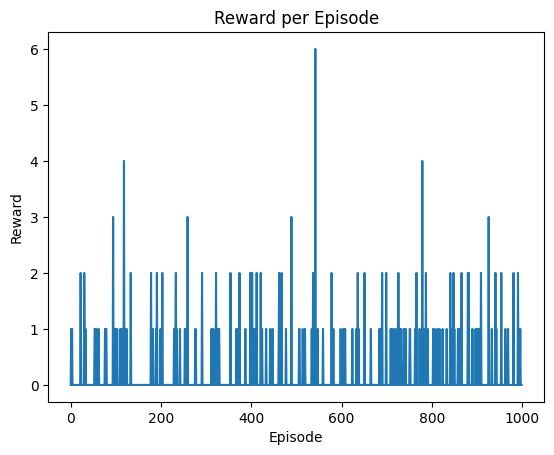

Episode 1000: Total Reward: 0.0, Epsilon: 0.9726571000009002,frame_count: 30381
Episode 1001: Total Reward: 0.0, Epsilon: 0.9726364000009009,frame_count: 30404
Episode 1002: Total Reward: 2.0, Epsilon: 0.9725500000009037,frame_count: 30500
Episode 1003: Total Reward: 0.0, Epsilon: 0.9725293000009044,frame_count: 30523
Episode 1004: Total Reward: 0.0, Epsilon: 0.9725086000009051,frame_count: 30546
Episode 1005: Total Reward: 0.0, Epsilon: 0.9724879000009058,frame_count: 30569
Episode 1006: Total Reward: 0.0, Epsilon: 0.9724672000009065,frame_count: 30592
Episode 1007: Total Reward: 0.0, Epsilon: 0.9724465000009072,frame_count: 30615
Episode 1008: Total Reward: 0.0, Epsilon: 0.9724258000009078,frame_count: 30638
Episode 1009: Total Reward: 5.0, Epsilon: 0.9722359000009141,frame_count: 30849
Episode 1010: Total Reward: 0.0, Epsilon: 0.9722170000009147,frame_count: 30870
Episode 1011: Total Reward: 0.0, Epsilon: 0.9721963000009154,frame_count: 30893
Episode 1012: Total Reward: 0.0, Epsilon

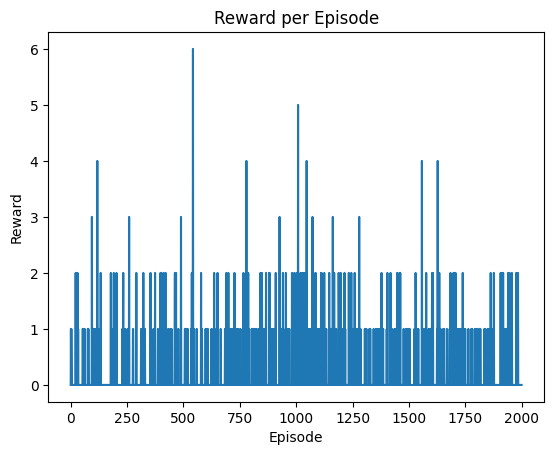

Episode 2000: Total Reward: 0.0, Epsilon: 0.9444376000018293,frame_count: 61736
Episode 2001: Total Reward: 1.0, Epsilon: 0.9443755000018313,frame_count: 61805
Episode 2002: Total Reward: 0.0, Epsilon: 0.944354800001832,frame_count: 61828
Episode 2003: Total Reward: 0.0, Epsilon: 0.9443341000018327,frame_count: 61851
Episode 2004: Total Reward: 0.0, Epsilon: 0.9443134000018334,frame_count: 61874
Episode 2005: Total Reward: 1.0, Epsilon: 0.9442522000018354,frame_count: 61942
Episode 2006: Total Reward: 0.0, Epsilon: 0.9442315000018361,frame_count: 61965
Episode 2007: Total Reward: 1.0, Epsilon: 0.9441712000018381,frame_count: 62032
Episode 2008: Total Reward: 0.0, Epsilon: 0.9441505000018388,frame_count: 62055
Episode 2009: Total Reward: 0.0, Epsilon: 0.9441298000018394,frame_count: 62078
Episode 2010: Total Reward: 0.0, Epsilon: 0.9441091000018401,frame_count: 62101
Episode 2011: Total Reward: 0.0, Epsilon: 0.9440884000018408,frame_count: 62124
Episode 2012: Total Reward: 0.0, Epsilon:

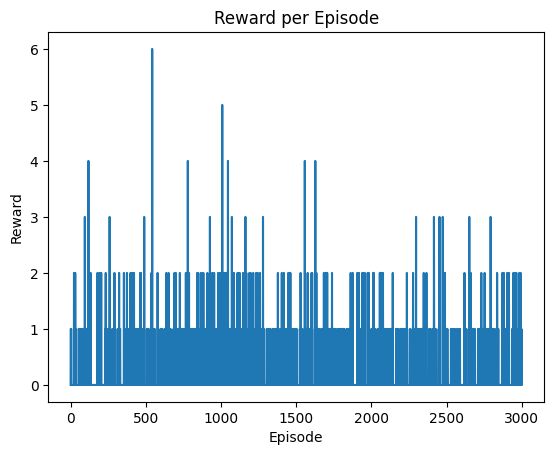

Episode 3000: Total Reward: 0.0, Epsilon: 0.9176833000027101,frame_count: 91463
Episode 3001: Total Reward: 0.0, Epsilon: 0.9176626000027108,frame_count: 91486
Episode 3002: Total Reward: 2.0, Epsilon: 0.9175699000027139,frame_count: 91589
Episode 3003: Total Reward: 1.0, Epsilon: 0.9175222000027154,frame_count: 91642
Episode 3004: Total Reward: 0.0, Epsilon: 0.9175015000027161,frame_count: 91665
Episode 3005: Total Reward: 0.0, Epsilon: 0.9174808000027168,frame_count: 91688
Episode 3006: Total Reward: 0.0, Epsilon: 0.9174601000027175,frame_count: 91711
Episode 3007: Total Reward: 0.0, Epsilon: 0.9174394000027182,frame_count: 91734
Episode 3008: Total Reward: 0.0, Epsilon: 0.9174205000027188,frame_count: 91755
Episode 3009: Total Reward: 0.0, Epsilon: 0.9173998000027195,frame_count: 91778
Episode 3010: Total Reward: 0.0, Epsilon: 0.9173791000027202,frame_count: 91801
Episode 3011: Total Reward: 0.0, Epsilon: 0.9173584000027208,frame_count: 91824
Episode 3012: Total Reward: 0.0, Epsilon

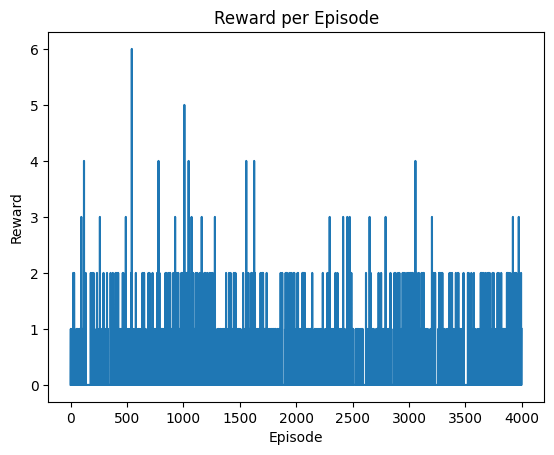

Episode 4000: Total Reward: 1.0, Epsilon: 0.8897716000036291,frame_count: 122476
Episode 4001: Total Reward: 0.0, Epsilon: 0.8897509000036298,frame_count: 122499
Episode 4002: Total Reward: 1.0, Epsilon: 0.8896888000036318,frame_count: 122568
Episode 4003: Total Reward: 0.0, Epsilon: 0.8896681000036325,frame_count: 122591
Episode 4004: Total Reward: 2.0, Epsilon: 0.8895817000036353,frame_count: 122687
Episode 4005: Total Reward: 0.0, Epsilon: 0.889561000003636,frame_count: 122710
Episode 4006: Total Reward: 0.0, Epsilon: 0.8895403000036367,frame_count: 122733
Episode 4007: Total Reward: 0.0, Epsilon: 0.8895196000036374,frame_count: 122756
Episode 4008: Total Reward: 0.0, Epsilon: 0.8894989000036381,frame_count: 122779
Episode 4009: Total Reward: 0.0, Epsilon: 0.8894782000036388,frame_count: 122802
Episode 4010: Total Reward: 0.0, Epsilon: 0.8894575000036394,frame_count: 122825
Episode 4011: Total Reward: 0.0, Epsilon: 0.8894368000036401,frame_count: 122848
Episode 4012: Total Reward: 0

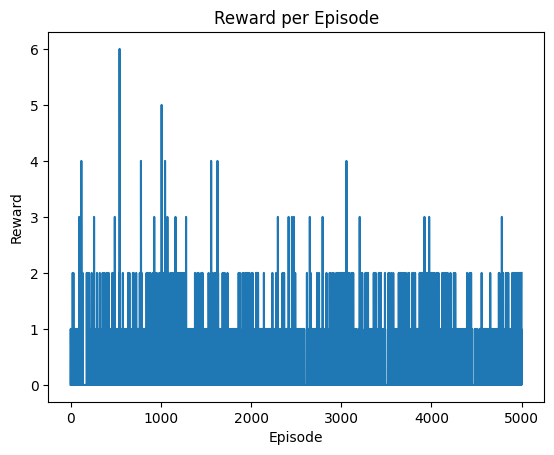

Episode 5000: Total Reward: 2.0, Epsilon: 0.8628850000045143,frame_count: 152350
Episode 5001: Total Reward: 0.0, Epsilon: 0.862864300004515,frame_count: 152373
Episode 5002: Total Reward: 0.0, Epsilon: 0.8628436000045157,frame_count: 152396
Episode 5003: Total Reward: 0.0, Epsilon: 0.8628229000045163,frame_count: 152419
Episode 5004: Total Reward: 0.0, Epsilon: 0.862802200004517,frame_count: 152442
Episode 5005: Total Reward: 0.0, Epsilon: 0.8627833000045176,frame_count: 152463
Episode 5006: Total Reward: 0.0, Epsilon: 0.8627626000045183,frame_count: 152486
Episode 5007: Total Reward: 0.0, Epsilon: 0.862741900004519,frame_count: 152509
Episode 5008: Total Reward: 0.0, Epsilon: 0.8627212000045197,frame_count: 152532
Episode 5009: Total Reward: 0.0, Epsilon: 0.8627005000045204,frame_count: 152555
Episode 5010: Total Reward: 0.0, Epsilon: 0.862679800004521,frame_count: 152578
Episode 5011: Total Reward: 0.0, Epsilon: 0.8626591000045217,frame_count: 152601
Episode 5012: Total Reward: 2.0,

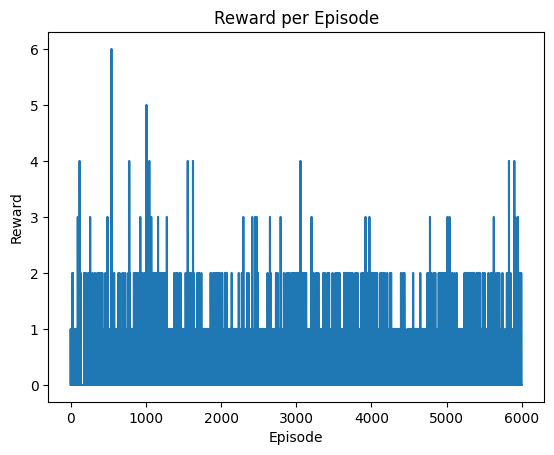

Episode 6000: Total Reward: 0.0, Epsilon: 0.8341084000054617,frame_count: 184324
Episode 6001: Total Reward: 1.0, Epsilon: 0.8340625000054632,frame_count: 184375
Episode 6002: Total Reward: 0.0, Epsilon: 0.8340436000054638,frame_count: 184396
Episode 6003: Total Reward: 1.0, Epsilon: 0.8339959000054654,frame_count: 184449
Episode 6004: Total Reward: 0.0, Epsilon: 0.8339752000054661,frame_count: 184472
Episode 6005: Total Reward: 0.0, Epsilon: 0.8339545000054668,frame_count: 184495
Episode 6006: Total Reward: 0.0, Epsilon: 0.8339338000054675,frame_count: 184518
Episode 6007: Total Reward: 0.0, Epsilon: 0.8339131000054681,frame_count: 184541
Episode 6008: Total Reward: 0.0, Epsilon: 0.8338924000054688,frame_count: 184564
Episode 6009: Total Reward: 0.0, Epsilon: 0.8338717000054695,frame_count: 184587
Episode 6010: Total Reward: 0.0, Epsilon: 0.8338510000054702,frame_count: 184610
Episode 6011: Total Reward: 0.0, Epsilon: 0.8338303000054709,frame_count: 184633
Episode 6012: Total Reward: 

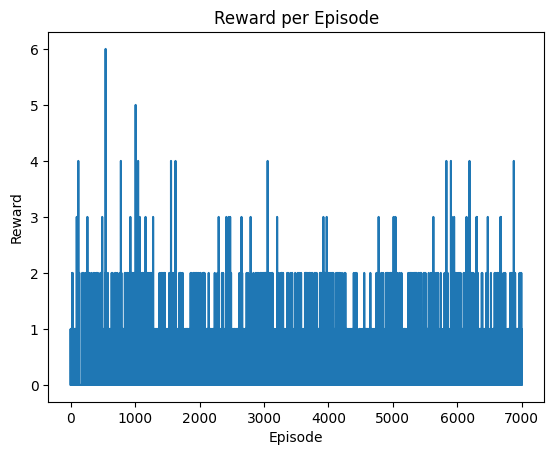

Episode 7000: Total Reward: 0.0, Epsilon: 0.8048728000064242,frame_count: 216808
Episode 7001: Total Reward: 0.0, Epsilon: 0.8048521000064249,frame_count: 216831
Episode 7002: Total Reward: 0.0, Epsilon: 0.8048314000064256,frame_count: 216854
Episode 7003: Total Reward: 0.0, Epsilon: 0.8048107000064263,frame_count: 216877
Episode 7004: Total Reward: 1.0, Epsilon: 0.8047495000064283,frame_count: 216945
Episode 7005: Total Reward: 1.0, Epsilon: 0.8047036000064298,frame_count: 216996
Episode 7006: Total Reward: 0.0, Epsilon: 0.8046829000064305,frame_count: 217019
Episode 7007: Total Reward: 0.0, Epsilon: 0.8046640000064311,frame_count: 217040
Episode 7008: Total Reward: 0.0, Epsilon: 0.8046451000064317,frame_count: 217061
Episode 7009: Total Reward: 1.0, Epsilon: 0.8045992000064333,frame_count: 217112
Episode 7010: Total Reward: 0.0, Epsilon: 0.8045794000064339,frame_count: 217134
Episode 7011: Total Reward: 0.0, Epsilon: 0.8045587000064346,frame_count: 217157
Episode 7012: Total Reward: 

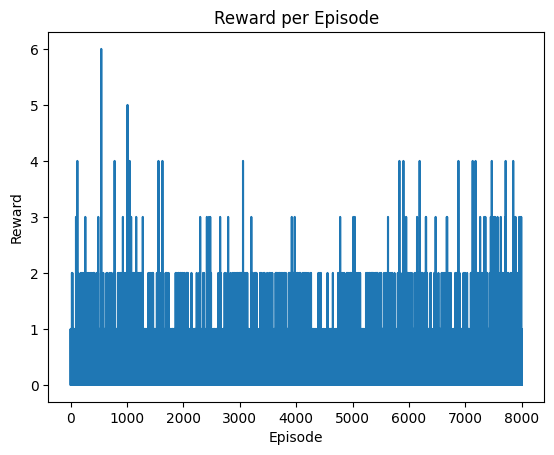

Episode 8000: Total Reward: 0.0, Epsilon: 0.7719922000075068,frame_count: 253342
Episode 8001: Total Reward: 1.0, Epsilon: 0.7719463000075083,frame_count: 253393
Episode 8002: Total Reward: 0.0, Epsilon: 0.7719274000075089,frame_count: 253414
Episode 8003: Total Reward: 0.0, Epsilon: 0.7719067000075096,frame_count: 253437
Episode 8004: Total Reward: 2.0, Epsilon: 0.7718005000075131,frame_count: 253555
Episode 8005: Total Reward: 0.0, Epsilon: 0.7717798000075138,frame_count: 253578
Episode 8006: Total Reward: 0.0, Epsilon: 0.7717591000075145,frame_count: 253601
Episode 8007: Total Reward: 0.0, Epsilon: 0.7717384000075151,frame_count: 253624
Episode 8008: Total Reward: 0.0, Epsilon: 0.7717177000075158,frame_count: 253647
Episode 8009: Total Reward: 0.0, Epsilon: 0.7716988000075164,frame_count: 253668
Episode 8010: Total Reward: 0.0, Epsilon: 0.7716781000075171,frame_count: 253691
Episode 8011: Total Reward: 1.0, Epsilon: 0.7716322000075186,frame_count: 253742
Episode 8012: Total Reward: 

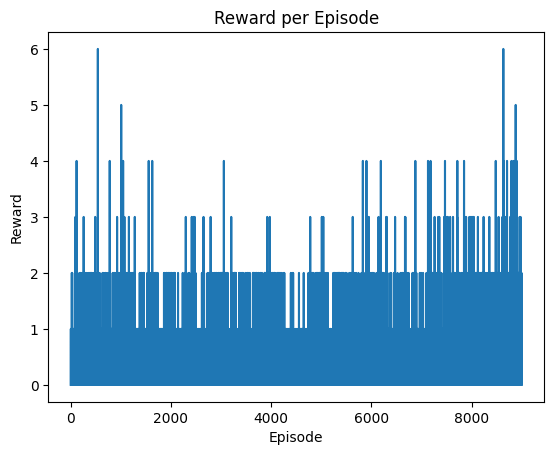

Episode 9000: Total Reward: 0.0, Epsilon: 0.7369228000086614,frame_count: 292308
Episode 9001: Total Reward: 0.0, Epsilon: 0.7369021000086621,frame_count: 292331
Episode 9002: Total Reward: 0.0, Epsilon: 0.7368814000086628,frame_count: 292354
Episode 9003: Total Reward: 0.0, Epsilon: 0.7368607000086634,frame_count: 292377
Episode 9004: Total Reward: 0.0, Epsilon: 0.7368400000086641,frame_count: 292400
Episode 9005: Total Reward: 2.0, Epsilon: 0.736753600008667,frame_count: 292496
Episode 9006: Total Reward: 0.0, Epsilon: 0.7367329000086676,frame_count: 292519
Episode 9007: Total Reward: 1.0, Epsilon: 0.7366681000086698,frame_count: 292591
Episode 9008: Total Reward: 1.0, Epsilon: 0.7366222000086713,frame_count: 292642
Episode 9009: Total Reward: 1.0, Epsilon: 0.7365556000086735,frame_count: 292716
Episode 9010: Total Reward: 1.0, Epsilon: 0.7364890000086757,frame_count: 292790
Episode 9011: Total Reward: 0.0, Epsilon: 0.7364683000086764,frame_count: 292813
Episode 9012: Total Reward: 0

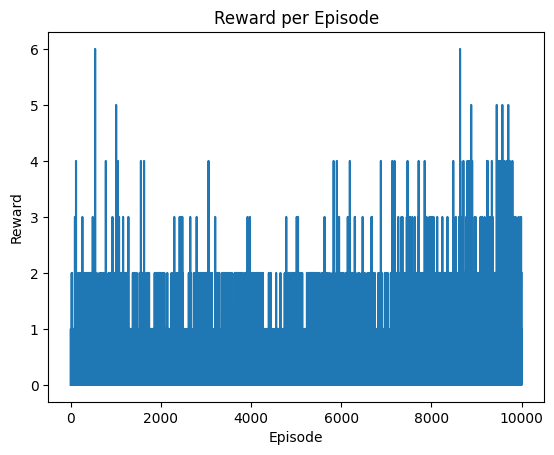

Episode 10000: Total Reward: 2.0, Epsilon: 0.6997150000098864,frame_count: 333650
Episode 10001: Total Reward: 0.0, Epsilon: 0.6996943000098871,frame_count: 333673
Episode 10002: Total Reward: 2.0, Epsilon: 0.6996079000098899,frame_count: 333769
Episode 10003: Total Reward: 0.0, Epsilon: 0.6995872000098906,frame_count: 333792
Episode 10004: Total Reward: 1.0, Epsilon: 0.6995251000098927,frame_count: 333861
Episode 10005: Total Reward: 0.0, Epsilon: 0.6995044000098933,frame_count: 333884
Episode 10006: Total Reward: 0.0, Epsilon: 0.699483700009894,frame_count: 333907
Episode 10007: Total Reward: 0.0, Epsilon: 0.6994630000098947,frame_count: 333930
Episode 10008: Total Reward: 2.0, Epsilon: 0.6993766000098975,frame_count: 334026
Episode 10009: Total Reward: 0.0, Epsilon: 0.6993559000098982,frame_count: 334049
Episode 10010: Total Reward: 0.0, Epsilon: 0.6993352000098989,frame_count: 334072
Episode 10011: Total Reward: 3.0, Epsilon: 0.6992038000099032,frame_count: 334218
Episode 10012: To

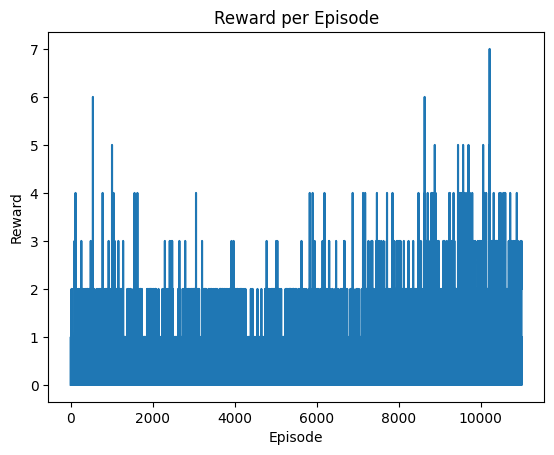

Episode 11000: Total Reward: 2.0, Epsilon: 0.6621229000111241,frame_count: 375419
Episode 11001: Total Reward: 0.0, Epsilon: 0.6621022000111247,frame_count: 375442
Episode 11002: Total Reward: 0.0, Epsilon: 0.6620815000111254,frame_count: 375465
Episode 11003: Total Reward: 1.0, Epsilon: 0.6620212000111274,frame_count: 375532
Episode 11004: Total Reward: 0.0, Epsilon: 0.6620005000111281,frame_count: 375555
Episode 11005: Total Reward: 0.0, Epsilon: 0.6619798000111288,frame_count: 375578
Episode 11006: Total Reward: 0.0, Epsilon: 0.6619591000111295,frame_count: 375601
Episode 11007: Total Reward: 0.0, Epsilon: 0.6619384000111301,frame_count: 375624
Episode 11008: Total Reward: 1.0, Epsilon: 0.6618736000111323,frame_count: 375696
Episode 11009: Total Reward: 2.0, Epsilon: 0.6617818000111353,frame_count: 375798
Episode 11010: Total Reward: 0.0, Epsilon: 0.6617629000111359,frame_count: 375819
Episode 11011: Total Reward: 1.0, Epsilon: 0.661698100011138,frame_count: 375891
Episode 11012: To

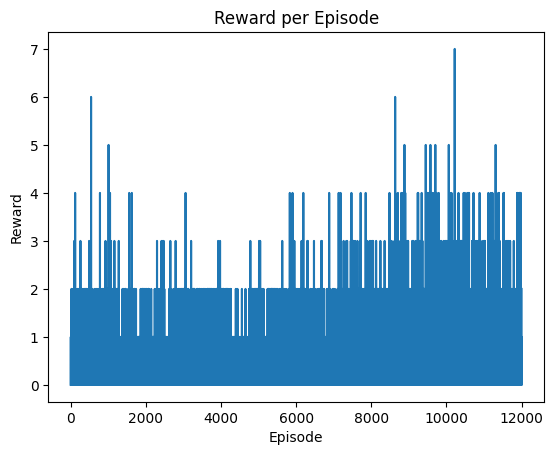

Episode 12000: Total Reward: 2.0, Epsilon: 0.6277249000122566,frame_count: 413639
Episode 12001: Total Reward: 0.0, Epsilon: 0.6277042000122572,frame_count: 413662
Episode 12002: Total Reward: 0.0, Epsilon: 0.6276835000122579,frame_count: 413685
Episode 12003: Total Reward: 0.0, Epsilon: 0.6276628000122586,frame_count: 413708
Episode 12004: Total Reward: 0.0, Epsilon: 0.6276421000122593,frame_count: 413731
Episode 12005: Total Reward: 1.0, Epsilon: 0.6275809000122613,frame_count: 413799
Episode 12006: Total Reward: 1.0, Epsilon: 0.6275161000122634,frame_count: 413871
Episode 12007: Total Reward: 0.0, Epsilon: 0.6274954000122641,frame_count: 413894
Episode 12008: Total Reward: 0.0, Epsilon: 0.6274765000122647,frame_count: 413915
Episode 12009: Total Reward: 0.0, Epsilon: 0.6274558000122654,frame_count: 413938
Episode 12010: Total Reward: 1.0, Epsilon: 0.6273892000122676,frame_count: 414012
Episode 12011: Total Reward: 0.0, Epsilon: 0.6273685000122683,frame_count: 414035
Episode 12012: T

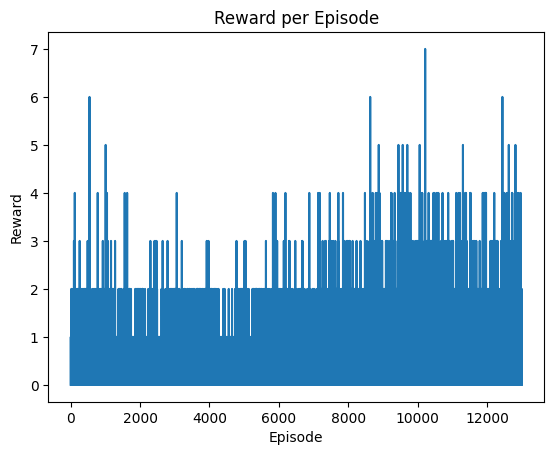

Episode 13000: Total Reward: 0.0, Epsilon: 0.59025970001349,frame_count: 455267
Episode 13001: Total Reward: 1.0, Epsilon: 0.5901949000134922,frame_count: 455339
Episode 13002: Total Reward: 0.0, Epsilon: 0.5901742000134929,frame_count: 455362
Episode 13003: Total Reward: 1.0, Epsilon: 0.5901139000134948,frame_count: 455429
Episode 13004: Total Reward: 0.0, Epsilon: 0.5900932000134955,frame_count: 455452
Episode 13005: Total Reward: 0.0, Epsilon: 0.5900725000134962,frame_count: 455475
Episode 13006: Total Reward: 0.0, Epsilon: 0.5900518000134969,frame_count: 455498
Episode 13007: Total Reward: 2.0, Epsilon: 0.5899411000135005,frame_count: 455621
Episode 13008: Total Reward: 3.0, Epsilon: 0.5898214000135045,frame_count: 455754
Episode 13009: Total Reward: 2.0, Epsilon: 0.5897161000135079,frame_count: 455871
Episode 13010: Total Reward: 0.0, Epsilon: 0.5896954000135086,frame_count: 455894
Episode 13011: Total Reward: 0.0, Epsilon: 0.5896747000135093,frame_count: 455917
Episode 13012: Tot

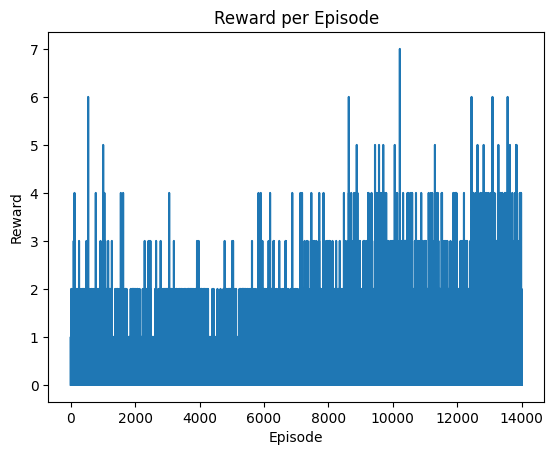

Episode 14000: Total Reward: 0.0, Epsilon: 0.5516587000147609,frame_count: 498157
Episode 14001: Total Reward: 0.0, Epsilon: 0.5516380000147616,frame_count: 498180
Episode 14002: Total Reward: 4.0, Epsilon: 0.5514688000147672,frame_count: 498368
Episode 14003: Total Reward: 0.0, Epsilon: 0.5514481000147679,frame_count: 498391
Episode 14004: Total Reward: 3.0, Epsilon: 0.5513131000147723,frame_count: 498541
Episode 14005: Total Reward: 0.0, Epsilon: 0.5512942000147729,frame_count: 498562
Episode 14006: Total Reward: 0.0, Epsilon: 0.5512735000147736,frame_count: 498585
Episode 14007: Total Reward: 0.0, Epsilon: 0.5512546000147742,frame_count: 498606
Episode 14008: Total Reward: 0.0, Epsilon: 0.5512339000147749,frame_count: 498629
Episode 14009: Total Reward: 0.0, Epsilon: 0.5512132000147756,frame_count: 498652
Episode 14010: Total Reward: 0.0, Epsilon: 0.5511943000147762,frame_count: 498673
Episode 14011: Total Reward: 2.0, Epsilon: 0.5510836000147799,frame_count: 498796
Episode 14012: T

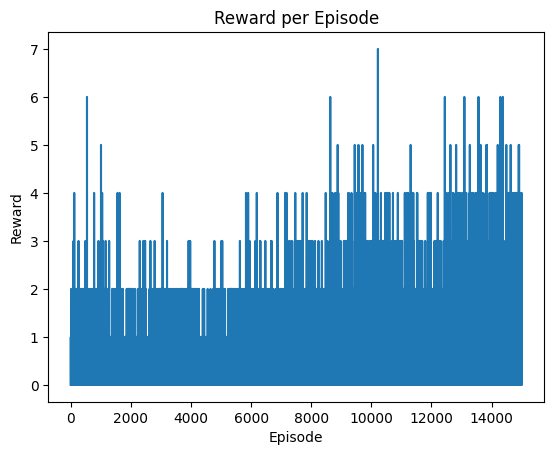

Episode 15000: Total Reward: 1.0, Epsilon: 0.5079124000162012,frame_count: 546764
Episode 15001: Total Reward: 0.0, Epsilon: 0.5078917000162019,frame_count: 546787
Episode 15002: Total Reward: 0.0, Epsilon: 0.5078710000162026,frame_count: 546810
Episode 15003: Total Reward: 3.0, Epsilon: 0.5077531000162064,frame_count: 546941
Episode 15004: Total Reward: 0.0, Epsilon: 0.5077324000162071,frame_count: 546964
Episode 15005: Total Reward: 1.0, Epsilon: 0.5076712000162091,frame_count: 547032
Episode 15006: Total Reward: 2.0, Epsilon: 0.507583000016212,frame_count: 547130
Episode 15007: Total Reward: 0.0, Epsilon: 0.5075623000162127,frame_count: 547153
Episode 15008: Total Reward: 0.0, Epsilon: 0.5075416000162134,frame_count: 547176
Episode 15009: Total Reward: 0.0, Epsilon: 0.5075209000162141,frame_count: 547199
Episode 15010: Total Reward: 2.0, Epsilon: 0.5074282000162171,frame_count: 547302
Episode 15011: Total Reward: 3.0, Epsilon: 0.5072770000162221,frame_count: 547470
Episode 15012: To

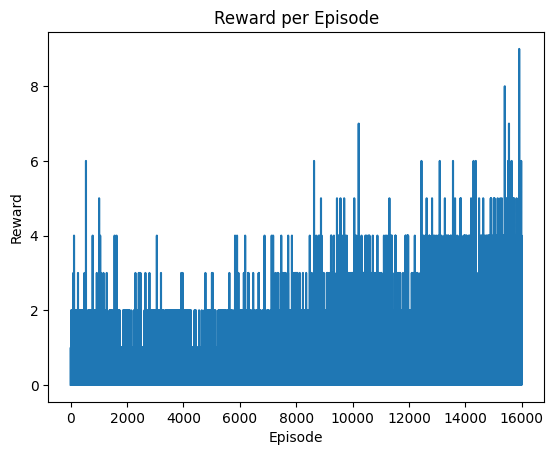

Episode 16000: Total Reward: 3.0, Epsilon: 0.45118810001505805,frame_count: 609791
Episode 16001: Total Reward: 2.0, Epsilon: 0.45108010001505494,frame_count: 609911
loss: 0.0016
Episode 16002: Total Reward: 4.0, Epsilon: 0.4509298000150506,frame_count: 610078
Episode 16003: Total Reward: 0.0, Epsilon: 0.45090910001505,frame_count: 610101
Episode 16004: Total Reward: 1.0, Epsilon: 0.4508632000150487,frame_count: 610152
Episode 16005: Total Reward: 0.0, Epsilon: 0.4508425000150481,frame_count: 610175
Episode 16006: Total Reward: 2.0, Epsilon: 0.450768700015046,frame_count: 610257
Episode 16007: Total Reward: 0.0, Epsilon: 0.45074980001504544,frame_count: 610278
Episode 16008: Total Reward: 0.0, Epsilon: 0.45072910001504485,frame_count: 610301
Episode 16009: Total Reward: 0.0, Epsilon: 0.45070840001504425,frame_count: 610324
Episode 16010: Total Reward: 0.0, Epsilon: 0.45068770001504366,frame_count: 610347
Episode 16011: Total Reward: 0.0, Epsilon: 0.45066700001504306,frame_count: 610370

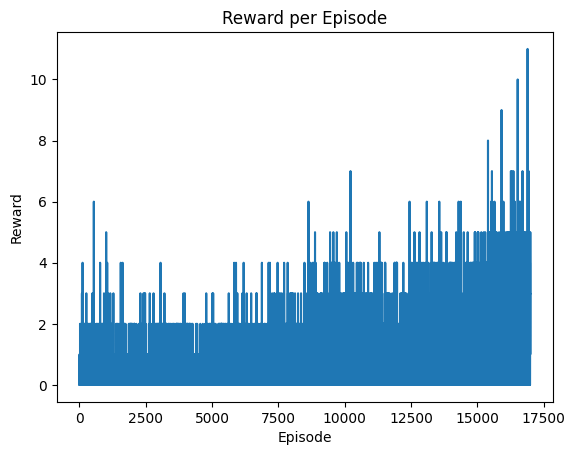

Episode 17000: Total Reward: 3.0, Epsilon: 0.3823174000130776,frame_count: 686314
Episode 17001: Total Reward: 0.0, Epsilon: 0.38229670001307703,frame_count: 686337
Episode 17002: Total Reward: 2.0, Epsilon: 0.3822229000130749,frame_count: 686419
Episode 17003: Total Reward: 1.0, Epsilon: 0.3821599000130731,frame_count: 686489
Episode 17004: Total Reward: 3.0, Epsilon: 0.3820393000130696,frame_count: 686623
Episode 17005: Total Reward: 5.0, Epsilon: 0.38186290001306455,frame_count: 686819
Episode 17006: Total Reward: 1.0, Epsilon: 0.3817981000130627,frame_count: 686891
Episode 17007: Total Reward: 0.0, Epsilon: 0.3817774000130621,frame_count: 686914
Episode 17008: Total Reward: 5.0, Epsilon: 0.38161900001305754,frame_count: 687090
Episode 17009: Total Reward: 0.0, Epsilon: 0.381600100013057,frame_count: 687111
Episode 17010: Total Reward: 6.0, Epsilon: 0.3814156000130517,frame_count: 687316
Episode 17011: Total Reward: 6.0, Epsilon: 0.381217600013046,frame_count: 687536
Episode 17012: 

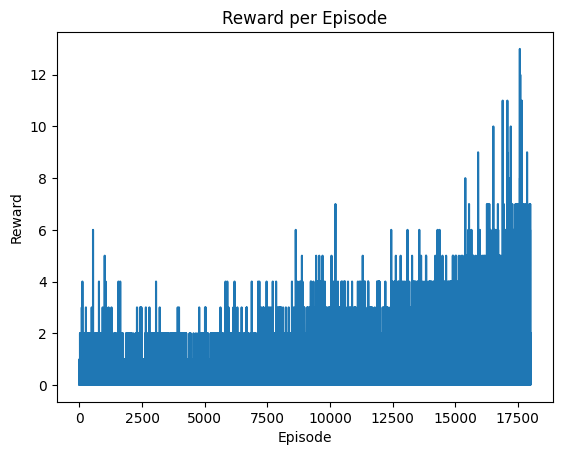

Episode 18000: Total Reward: 2.0, Epsilon: 0.29775700001064603,frame_count: 780270
Episode 18001: Total Reward: 4.0, Epsilon: 0.2976022000106416,frame_count: 780442
Episode 18002: Total Reward: 0.0, Epsilon: 0.29758330001064104,frame_count: 780463
Episode 18003: Total Reward: 1.0, Epsilon: 0.2975167000106391,frame_count: 780537
Episode 18004: Total Reward: 1.0, Epsilon: 0.2974501000106372,frame_count: 780611
Episode 18005: Total Reward: 1.0, Epsilon: 0.2973808000106352,frame_count: 780688
Episode 18006: Total Reward: 3.0, Epsilon: 0.29724580001063133,frame_count: 780838
Episode 18007: Total Reward: 3.0, Epsilon: 0.2971261000106279,frame_count: 780971
Episode 18008: Total Reward: 1.0, Epsilon: 0.2970775000106265,frame_count: 781025
Episode 18009: Total Reward: 4.0, Epsilon: 0.2969245000106221,frame_count: 781195
Episode 18010: Total Reward: 6.0, Epsilon: 0.2967400000106168,frame_count: 781400
Episode 18011: Total Reward: 6.0, Epsilon: 0.29655730001061154,frame_count: 781603
Episode 1801

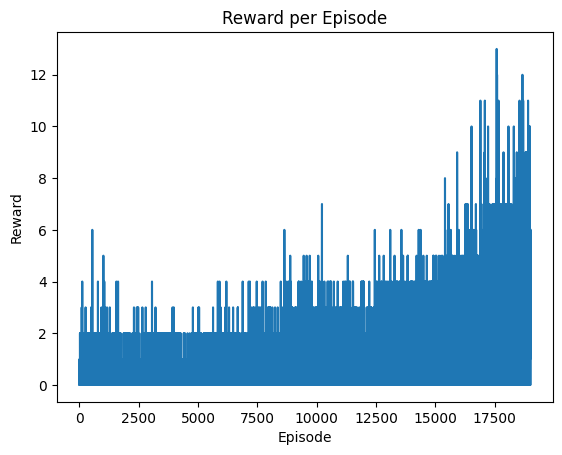

Episode 19000: Total Reward: 6.0, Epsilon: 0.19886320000937932,frame_count: 890152
Episode 19001: Total Reward: 3.0, Epsilon: 0.1987336000093796,frame_count: 890296
Episode 19002: Total Reward: 4.0, Epsilon: 0.1985815000093799,frame_count: 890465
Episode 19003: Total Reward: 0.0, Epsilon: 0.19856080000937995,frame_count: 890488
Episode 19004: Total Reward: 2.0, Epsilon: 0.1984870000093801,frame_count: 890570
Episode 19005: Total Reward: 0.0, Epsilon: 0.19846810000938014,frame_count: 890591
Episode 19006: Total Reward: 1.0, Epsilon: 0.19842220000938024,frame_count: 890642
Episode 19007: Total Reward: 2.0, Epsilon: 0.19833220000938043,frame_count: 890742
Episode 19008: Total Reward: 3.0, Epsilon: 0.1981999000093807,frame_count: 890889
Episode 19009: Total Reward: 5.0, Epsilon: 0.19802440000938107,frame_count: 891084
Episode 19010: Total Reward: 1.0, Epsilon: 0.19797670000938117,frame_count: 891137
Episode 19011: Total Reward: 0.0, Epsilon: 0.1979560000093812,frame_count: 891160
Episode 1

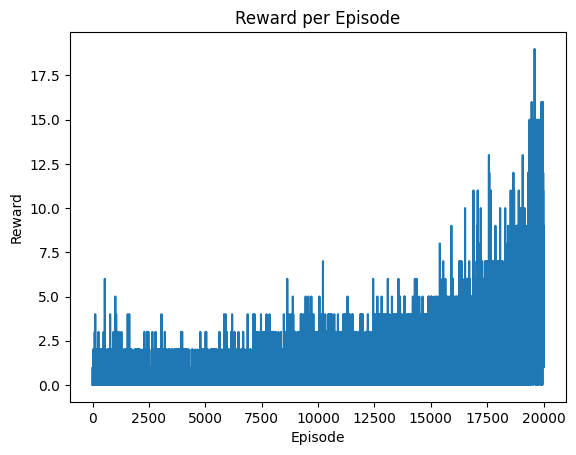

Episode 20000: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1042761
Episode 20001: Total Reward: 15.0, Epsilon: 0.1,frame_count: 1043273
Episode 20002: Total Reward: 5.0, Epsilon: 0.1,frame_count: 1043454
Episode 20003: Total Reward: 9.0, Epsilon: 0.1,frame_count: 1043811
Episode 20004: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1043855
Episode 20005: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1043900
Episode 20006: Total Reward: 18.0, Epsilon: 0.1,frame_count: 1044468
Episode 20007: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1044603
Episode 20008: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1044777
Episode 20009: Total Reward: 5.0, Epsilon: 0.1,frame_count: 1044966
Episode 20010: Total Reward: 6.0, Epsilon: 0.1,frame_count: 1045169
Episode 20011: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1045597
Episode 20012: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1046024
Episode 20013: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1046129
Episode 20014: Total Reward: 4.0, Epsilon: 0

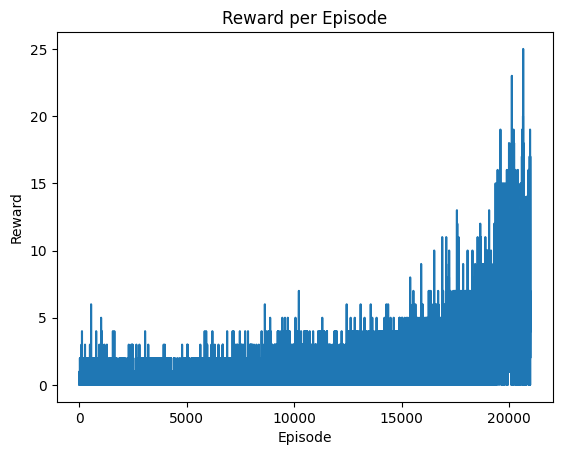

Episode 21000: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1234559
Episode 21001: Total Reward: 6.0, Epsilon: 0.1,frame_count: 1234758
Episode 21002: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1235170
Episode 21003: Total Reward: 13.0, Epsilon: 0.1,frame_count: 1235652
Episode 21004: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1235802
Episode 21005: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1235846
Episode 21006: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1236265
Episode 21007: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1236420
Episode 21008: Total Reward: 14.0, Epsilon: 0.1,frame_count: 1236944
Episode 21009: Total Reward: 5.0, Epsilon: 0.1,frame_count: 1237131
Episode 21010: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1237175
Episode 21011: Total Reward: 18.0, Epsilon: 0.1,frame_count: 1237782
Episode 21012: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1237903
Episode 21013: Total Reward: 6.0, Epsilon: 0.1,frame_count: 1238091
Episode 21014: Total Reward: 4.0, Epsilon: 

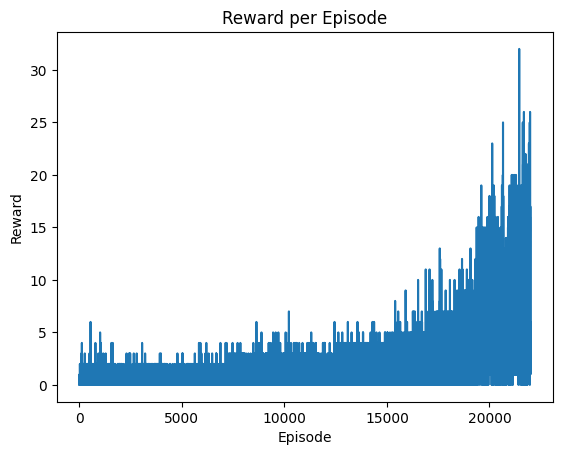

Episode 22000: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1454310
Episode 22001: Total Reward: 14.0, Epsilon: 0.1,frame_count: 1454794
Episode 22002: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1454935
Episode 22003: Total Reward: 13.0, Epsilon: 0.1,frame_count: 1455431
Episode 22004: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1455475
Episode 22005: Total Reward: 5.0, Epsilon: 0.1,frame_count: 1455681
Episode 22006: Total Reward: 7.0, Epsilon: 0.1,frame_count: 1455924
Episode 22007: Total Reward: 7.0, Epsilon: 0.1,frame_count: 1456189
Episode 22008: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1456242
Episode 22009: Total Reward: 17.0, Epsilon: 0.1,frame_count: 1456812
Episode 22010: Total Reward: 0.0, Epsilon: 0.1,frame_count: 1456834
Episode 22011: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1456963
Episode 22012: Total Reward: 8.0, Epsilon: 0.1,frame_count: 1457244
Episode 22013: Total Reward: 2.0, Epsilon: 0.1,frame_count: 1457328
Episode 22014: Total Reward: 7.0, Epsilon: 0.

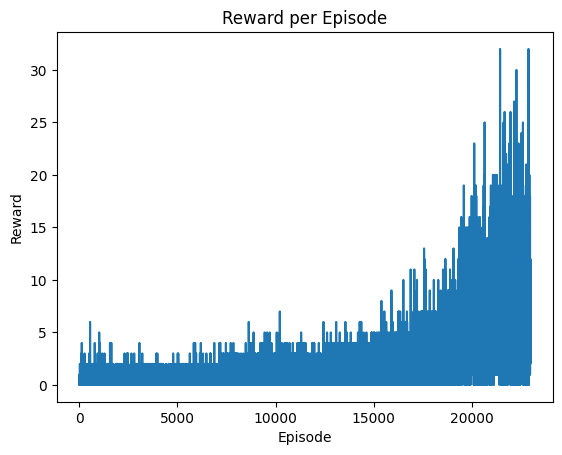

Episode 23000: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1675562
Episode 23001: Total Reward: 9.0, Epsilon: 0.1,frame_count: 1675885
Episode 23002: Total Reward: 6.0, Epsilon: 0.1,frame_count: 1676079
Episode 23003: Total Reward: 5.0, Epsilon: 0.1,frame_count: 1676282
Episode 23004: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1676326
Episode 23005: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1676371
Episode 23006: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1676789
Episode 23007: Total Reward: 11.0, Epsilon: 0.1,frame_count: 1677222
Episode 23008: Total Reward: 14.0, Epsilon: 0.1,frame_count: 1677732
Episode 23009: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1677807
Episode 23010: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1677852
Episode 23011: Total Reward: 20.0, Epsilon: 0.1,frame_count: 1678492
Episode 23012: Total Reward: 2.0, Epsilon: 0.1,frame_count: 1678577
Episode 23013: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1678631
Episode 23014: Total Reward: 8.0, Epsilon: 0

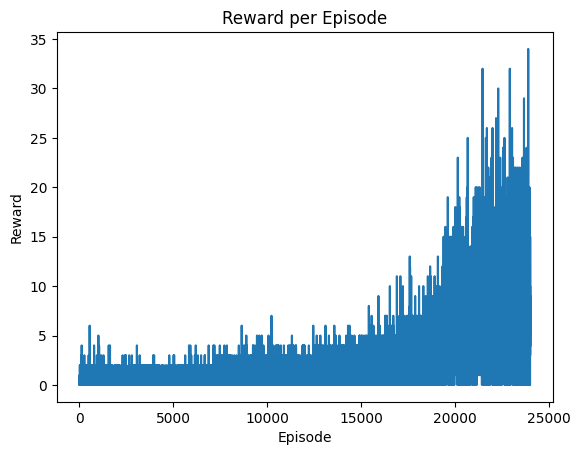

Episode 24000: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1900014
Episode 24001: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1900165
Episode 24002: Total Reward: 10.0, Epsilon: 0.1,frame_count: 1900543
Episode 24003: Total Reward: 10.0, Epsilon: 0.1,frame_count: 1900926
Episode 24004: Total Reward: 2.0, Epsilon: 0.1,frame_count: 1901035
Episode 24005: Total Reward: 1.0, Epsilon: 0.1,frame_count: 1901079
Episode 24006: Total Reward: 8.0, Epsilon: 0.1,frame_count: 1901354
Episode 24007: Total Reward: 4.0, Epsilon: 0.1,frame_count: 1901495
Episode 24008: Total Reward: 20.0, Epsilon: 0.1,frame_count: 1902140
Episode 24009: Total Reward: 7.0, Epsilon: 0.1,frame_count: 1902348
Episode 24010: Total Reward: 8.0, Epsilon: 0.1,frame_count: 1902571
Episode 24011: Total Reward: 3.0, Epsilon: 0.1,frame_count: 1902702
Episode 24012: Total Reward: 0.0, Epsilon: 0.1,frame_count: 1902725
Episode 24013: Total Reward: 10.0, Epsilon: 0.1,frame_count: 1903119
Episode 24014: Total Reward: 5.0, Epsilon: 0

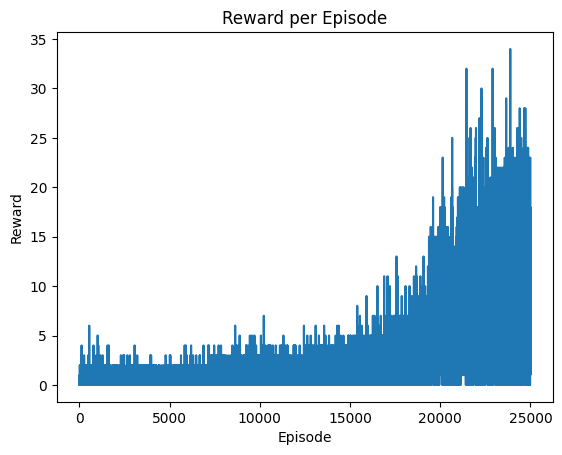

Episode 25000: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2131182
Episode 25001: Total Reward: 22.0, Epsilon: 0.1,frame_count: 2131871
Episode 25002: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2131960
Episode 25003: Total Reward: 6.0, Epsilon: 0.1,frame_count: 2132207
Episode 25004: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2132349
Episode 25005: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2132486
Episode 25006: Total Reward: 1.0, Epsilon: 0.1,frame_count: 2132537
Episode 25007: Total Reward: 13.0, Epsilon: 0.1,frame_count: 2132851
Episode 25008: Total Reward: 8.0, Epsilon: 0.1,frame_count: 2133096
Episode 25009: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2133255
Episode 25010: Total Reward: 0.0, Epsilon: 0.1,frame_count: 2133278
Episode 25011: Total Reward: 19.0, Epsilon: 0.1,frame_count: 2133870
Episode 25012: Total Reward: 7.0, Epsilon: 0.1,frame_count: 2134095
Episode 25013: Total Reward: 6.0, Epsilon: 0.1,frame_count: 2134282
Episode 25014: Total Reward: 4.0, Epsilon: 0.

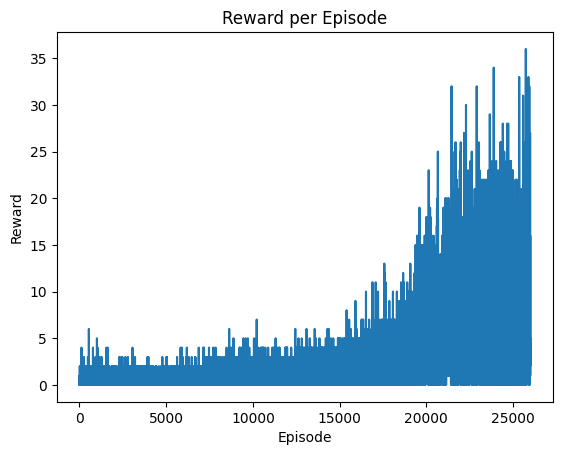

Episode 26000: Total Reward: 3.0, Epsilon: 0.1,frame_count: 2360474
Episode 26001: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2360558
Episode 26002: Total Reward: 35.0, Epsilon: 0.1,frame_count: 2361559
Episode 26003: Total Reward: 1.0, Epsilon: 0.1,frame_count: 2361603
Episode 26004: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2361663
Episode 26005: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2361769
Episode 26006: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2361945
Episode 26007: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2362028
Episode 26008: Total Reward: 11.0, Epsilon: 0.1,frame_count: 2362447
Episode 26009: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2362643
Episode 26010: Total Reward: 10.0, Epsilon: 0.1,frame_count: 2363020
Episode 26011: Total Reward: 17.0, Epsilon: 0.1,frame_count: 2363587
Episode 26012: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2363741
Episode 26013: Total Reward: 15.0, Epsilon: 0.1,frame_count: 2364291
Episode 26014: Total Reward: 4.0, Epsilon: 

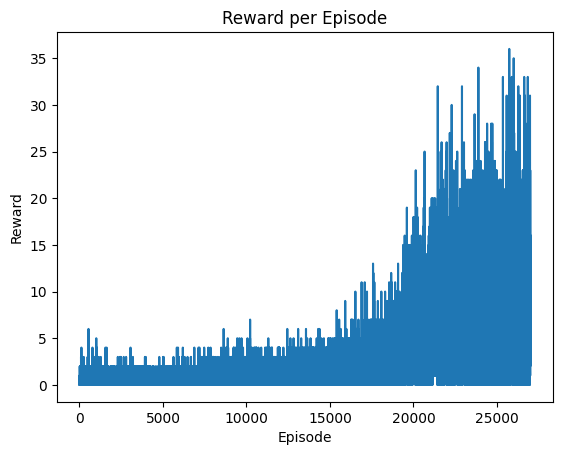

Episode 27000: Total Reward: 16.0, Epsilon: 0.1,frame_count: 2600666
Episode 27001: Total Reward: 13.0, Epsilon: 0.1,frame_count: 2601134
Episode 27002: Total Reward: 6.0, Epsilon: 0.1,frame_count: 2601341
Episode 27003: Total Reward: 13.0, Epsilon: 0.1,frame_count: 2601843
Episode 27004: Total Reward: 10.0, Epsilon: 0.1,frame_count: 2602206
Episode 27005: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2602266
Episode 27006: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2602445
Episode 27007: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2602623
Episode 27008: Total Reward: 8.0, Epsilon: 0.1,frame_count: 2602928
Episode 27009: Total Reward: 1.0, Epsilon: 0.1,frame_count: 2602983
Episode 27010: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2603085
Episode 27011: Total Reward: 6.0, Epsilon: 0.1,frame_count: 2603271
Episode 27012: Total Reward: 6.0, Epsilon: 0.1,frame_count: 2603473
Episode 27013: Total Reward: 20.0, Epsilon: 0.1,frame_count: 2604122
Episode 27014: Total Reward: 1.0, Epsilon: 

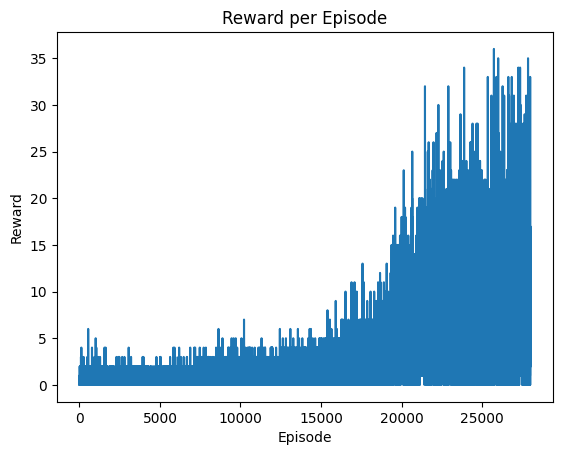

Episode 28000: Total Reward: 2.0, Epsilon: 0.1,frame_count: 2847995
Episode 28001: Total Reward: 11.0, Epsilon: 0.1,frame_count: 2848446
Episode 28002: Total Reward: 24.0, Epsilon: 0.1,frame_count: 2849156
Episode 28003: Total Reward: 1.0, Epsilon: 0.1,frame_count: 2849209
Episode 28004: Total Reward: 0.0, Epsilon: 0.1,frame_count: 2849230
Episode 28005: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2849391
Episode 28006: Total Reward: 5.0, Epsilon: 0.1,frame_count: 2849565
loss: 0.0042
Episode 28007: Total Reward: 16.0, Epsilon: 0.1,frame_count: 2850089
Episode 28008: Total Reward: 12.0, Epsilon: 0.1,frame_count: 2850561
Episode 28009: Total Reward: 9.0, Epsilon: 0.1,frame_count: 2850893
Episode 28010: Total Reward: 8.0, Epsilon: 0.1,frame_count: 2851171
Episode 28011: Total Reward: 1.0, Epsilon: 0.1,frame_count: 2851240
Episode 28012: Total Reward: 4.0, Epsilon: 0.1,frame_count: 2851393
Episode 28013: Total Reward: 12.0, Epsilon: 0.1,frame_count: 2851837
Episode 28014: Total Reward: 1

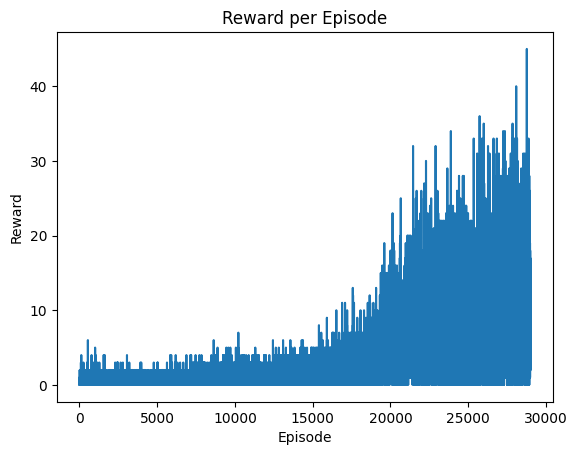

Episode 29000: Total Reward: 2.0, Epsilon: 0.1,frame_count: 3103377
Episode 29001: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3103826
Episode 29002: Total Reward: 20.0, Epsilon: 0.1,frame_count: 3104449
Episode 29003: Total Reward: 7.0, Epsilon: 0.1,frame_count: 3104588
Episode 29004: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3104682
Episode 29005: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3104765
Episode 29006: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3104941
Episode 29007: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3105071
Episode 29008: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3105124
Episode 29009: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3105284
Episode 29010: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3105443
Episode 29011: Total Reward: 2.0, Epsilon: 0.1,frame_count: 3105527
Episode 29012: Total Reward: 10.0, Epsilon: 0.1,frame_count: 3105914
Episode 29013: Total Reward: 16.0, Epsilon: 0.1,frame_count: 3106482
Episode 29014: Total Reward: 7.0, Epsilon: 0

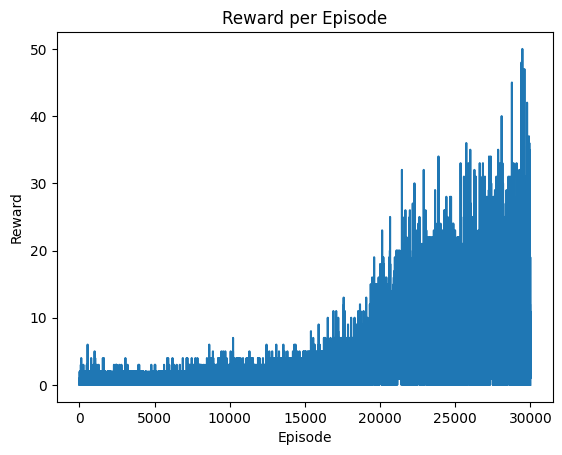

Episode 30000: Total Reward: 0.0, Epsilon: 0.1,frame_count: 3354325
Episode 30001: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3354456
Episode 30002: Total Reward: 12.0, Epsilon: 0.1,frame_count: 3354899
Episode 30003: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3355375
Episode 30004: Total Reward: 6.0, Epsilon: 0.1,frame_count: 3355606
Episode 30005: Total Reward: 8.0, Epsilon: 0.1,frame_count: 3355761
Episode 30006: Total Reward: 20.0, Epsilon: 0.1,frame_count: 3356405
Episode 30007: Total Reward: 2.0, Epsilon: 0.1,frame_count: 3356509
Episode 30008: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3356708
Episode 30009: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3356784
Episode 30010: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3356960
Episode 30011: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3357127
Episode 30012: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3357178
Episode 30013: Total Reward: 21.0, Epsilon: 0.1,frame_count: 3357845
Episode 30014: Total Reward: 9.0, Epsilon: 0

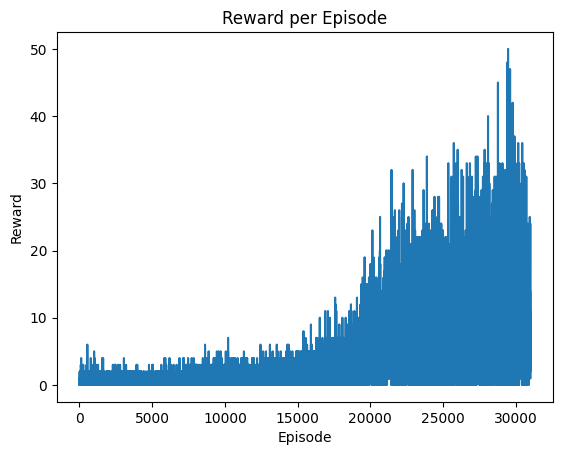

Episode 31000: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3607188
Episode 31001: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3607239
Episode 31002: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3607704
Episode 31003: Total Reward: 21.0, Epsilon: 0.1,frame_count: 3608362
Episode 31004: Total Reward: 10.0, Epsilon: 0.1,frame_count: 3608608
Episode 31005: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3608749
Episode 31006: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3609213
Episode 31007: Total Reward: 10.0, Epsilon: 0.1,frame_count: 3609583
Episode 31008: Total Reward: 9.0, Epsilon: 0.1,frame_count: 3609834
Episode 31009: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3609998
loss: 0.0032
Episode 31010: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3610104
Episode 31011: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3610278
Episode 31012: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3610331
Episode 31013: Total Reward: 9.0, Epsilon: 0.1,frame_count: 3610660
Episode 31014: Total Reward: 1

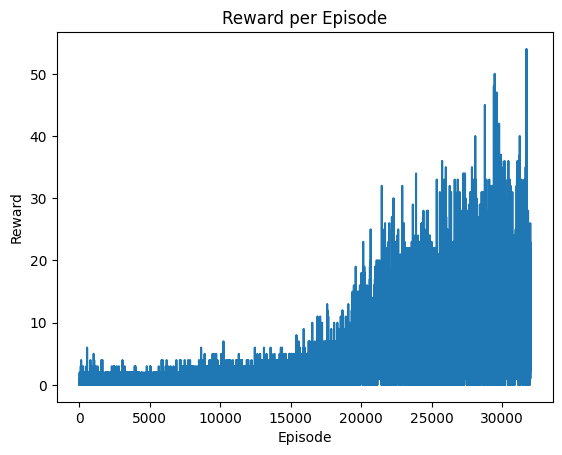

Episode 32000: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3857955
Episode 32001: Total Reward: 2.0, Epsilon: 0.1,frame_count: 3858057
Episode 32002: Total Reward: 1.0, Epsilon: 0.1,frame_count: 3858110
Episode 32003: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3858307
Episode 32004: Total Reward: 3.0, Epsilon: 0.1,frame_count: 3858434
Episode 32005: Total Reward: 12.0, Epsilon: 0.1,frame_count: 3858749
Episode 32006: Total Reward: 7.0, Epsilon: 0.1,frame_count: 3858972
Episode 32007: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3859156
Episode 32008: Total Reward: 13.0, Epsilon: 0.1,frame_count: 3859651
Episode 32009: Total Reward: 4.0, Epsilon: 0.1,frame_count: 3859809
Episode 32010: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3859965
loss: 0.0022
Episode 32011: Total Reward: 21.0, Epsilon: 0.1,frame_count: 3860611
Episode 32012: Total Reward: 14.0, Epsilon: 0.1,frame_count: 3860969
Episode 32013: Total Reward: 5.0, Epsilon: 0.1,frame_count: 3861154
Episode 32014: Total Reward: 3

In [ ]:


env=make_env()
env.reset()
print (env.observation_space.shape)
agent = DQNAgent(env)
agent.train()

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
env_test=make_env()
env_test.reset()
agent_test = DQNAgent(env_test)

n_games = 1

def evaluate1(env, agent_test, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    q_values_history = []
    actions_history = []
    temp = QNetwork(4)
    temp.load_state_dict(torch.load("/content/drive/MyDrive/Colab/dql_model_target_32000"))
    temp.eval()
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        q_values_episode = []
        actions_episode = []
        i=0
        for _ in range(t_max):
            state_tensor = torch.FloatTensor([s])
            qvalues = temp(state_tensor)
            q_values_episode.append(qvalues.detach().numpy())
            action = qvalues.argmax(axis=-1).item()
            actions_episode.append(action)
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              env.reset()
              i+=1
            if i==5:
              break
        rewards.append(reward)
    return np.mean(rewards)

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate1(env_monitor, agent, n_games=1, greedy=False) ]
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = max(video_paths, key=os.path.getctime)
print
if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

